# Week 1: Introduction to Computer Vision

## Notebook 3: Semantic Segmentation with a U-Net Convolutional Neural Network using PyTorch

Welcome to the fourth notebook of this week's Applied AI Study Group! We will study semantic segmentation problem with MSRC-v2 image dataset provided by Microsoft. The aim of our task will be to make object segmentation in the given images.

### 1. Semantic Segmentation

Semantic Segmentation aims to label each pixel (aka classify pixel-wise) of a given image. We treat different objects of the same class as they are same object. On contrast, instance segmentation treats each objects of the same class as they are different objects, hence, label them differently such as object 1, object 2, etc. In this notebook, we will tackle the problem of semantic segmentation. The pixel-wise operations can be applied via segmentation on images, for example, portrait mode in images requires to differentiate between foreground and background of an image. We blur out the pixels which are classified as background. 

So, how do we build our model for this case? We know that the capabilities of convolution filters are proven in terms of their capabilities in processing structured data such as images. However, they reduce the size of their input vector depends on their kernel size. We need a model that outputs the same size of input vector since we want to retrieve the same image we give into the model. Luckily for us, we have U-Net Architecture for these kind of tasks. We will study U-Nets in the following section.

### 2. U-Net Convolutional Neural Network

![U-Net Model Architecture](./images/u-net.jpg "Example U-Net")

We can divide the U-Net architecture into two parts while studying it: the left half of the network is responsible for information encoding and the right half of the network is responsible for information decoding.

* Encoder captures the context of image with a series of convolution and pooling operations, hence, it is responsible for feature extraction from the input image. 
* The middle layer between the encoder and the decoder is called bottlenecek representation of the input image. It is the high level feature representation of input data, e.g. objects and events. Using the information retrieved from each layer, we re-construct an output image with a same size as input image. For that, we utilize decoder of U-Net.
* Decoder upsamples the bottleneck representation to recover spatial locations (aka pixel-wise information) for assigning class labels to each pixel of the input image. For that, we recover the same size output image as the input image. During upsampling, we add extracted features from encoder part as in skip connections. We cannot afford to lose much information during encoding-decoding. Therefore, we need low-level features such as edges to have better results in classifying pixels.

### 3. Imports and Checks

You should have installed Numpy and Matplotlib using `pip` and, PyTorch using [Week 0 - Notebook 2](https://github.com/inzva/Applied-AI-Study-Group/blob/add-frameworks-week/Applied%20AI%20Study%20Group%20%236%20-%20January%202022/Week%200/2-mnist_classification_convnet_pytorch.ipynb).

The python file segmentation_dataset.py and MSRC-v2 image dataset can be found in the following link: [Segmentation](https://drive.google.com/drive/u/1/folders/18bKQKwvjuXbjNDMI-ktRD6tet9tcxNkL)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from datasets.segmentation_dataset import SegmentationData, label_img_to_rgb

D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


If the following two code cells are running successfully, then, you are good to go further!

In [2]:
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.10.1+cu102
cuda:0


We will load the data using the code provided in segmentation_dataset.py

In [3]:
data_root = os.path.join('../../../applied ai datasets/datasets','segmentation')

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

The first print calls are for double-checking the data loading.

Then, we visualize a couple of example images to observe what our input images look like and what our output images should look like.

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


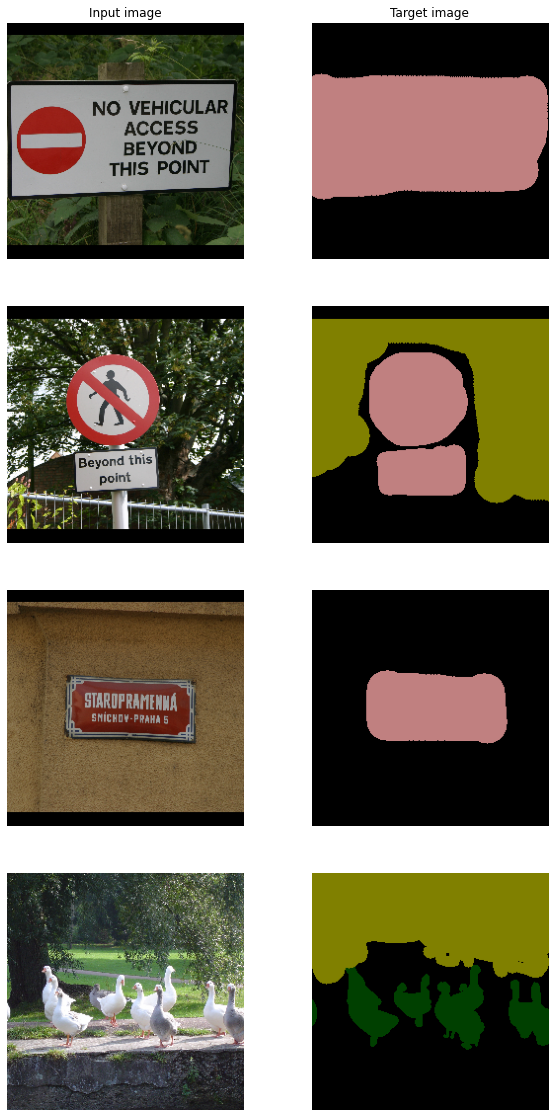

In [4]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

We will build our model in the following cell. Since semantic segmentation is a challenging task, we will use a pretrained model from torchvision for the encoder of our U-Net architecture. Then, we will build our decoder using Upsample, ConvTranspose2d, and LeakyReLU activation layers on top of MobileNet encoder.

One important note for pretrained model: We use [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) for its fast inference time. We don't need a more complex model with much inference time for the purpose of this notebook. You can check the models provided by [torchvision](https://pytorch.org/vision/0.8/models.html) for trying out different models. The MobileNet is trained with [ImageNet dataset](https://www.image-net.org/index.php). It is trained for classification task.  Hence, you can see that we exclude the last layer of MobileNet because we don't need the classifier layer but we need the rest of the network for feature extraction.

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

class SegmentationNN(nn.Module):

    def __init__(self, num_classes=23, hparams=None):
        super().__init__()
        self.hparams = hparams

        mobile_network = models.mobilenet_v2(pretrained=True)

        layers = list(mobile_network.children())[:-1]  # 1x1280x8x8
        layers.append(nn.Conv2d(1280, 120, 1, 1))  # 1x160x8x8
        layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Upsample(scale_factor=4))  # 1x160x32x32
        layers.append(nn.ConvTranspose2d(120, 80, 3, 2))  # 1x120x64x64
        layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.ConvTranspose2d(80, 60, 9, dilation=2))  # 1x80x80x80
        layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.ConvTranspose2d(60, 40, 9, dilation=2))  # 1x60x96x96
        layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.ConvTranspose2d(40, 40, 11, dilation=2))  # 1x40x116x116
        layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Upsample(scale_factor=2))  # 1x40x232x232
        layers.append(nn.ConvTranspose2d(40, 23, 7))  # 1x23x240x240
        layers.append(nn.LeakyReLU(0.1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):

        x = self.network(x)

        return x

We specify our training hyperparameters and set the rest of the adjustments for training.

In [77]:
hparams = {
    "lr" : 0.0001,
    "batch_size" : 4,
    "num_epochs" : 30
}  

model = SegmentationNN(hparams=hparams)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=hparams["batch_size"], shuffle=True)
print(train_loader)
print(next(iter(train_loader)))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

We do a test run for training loop to check if anything is wrong.

In [78]:
for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = model(inputs.unsqueeze(0).to(device))
    losses = criterion(outputs, targets.unsqueeze(0).to(device))
    print(losses)

tensor(3.1302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(3.1374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


Now, we train our model using the classical PyTorch training loop.

In [79]:
print('training starts!')
num_training_batches = len(train_loader)
num_validation_batches = len(val_loader)
num_testing_batches = len(test_loader)

for epoch in range(hparams["num_epochs"]):
    
    epoch_loss_training = 0.0
    epoch_loss_validation = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss_training += loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data[0].to(device), data[1].to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)
            epoch_loss_validation += loss.item()

    print("Epoch:  %2d\t|Training Loss:   %.3f\t|Validation Loss:   %.3f" % (epoch + 1, 
        epoch_loss_training / num_training_batches, 
        epoch_loss_validation / num_validation_batches))

training starts!
Epoch:   1	|Training Loss:   3.059	|Validation Loss:   2.757
Epoch:   2	|Training Loss:   2.672	|Validation Loss:   2.364
Epoch:   3	|Training Loss:   2.438	|Validation Loss:   2.107
Epoch:   4	|Training Loss:   2.212	|Validation Loss:   1.891
Epoch:   5	|Training Loss:   2.036	|Validation Loss:   1.832
Epoch:   6	|Training Loss:   1.870	|Validation Loss:   1.831
Epoch:   7	|Training Loss:   1.728	|Validation Loss:   1.648
Epoch:   8	|Training Loss:   1.577	|Validation Loss:   1.516
Epoch:   9	|Training Loss:   1.415	|Validation Loss:   1.463
Epoch:  10	|Training Loss:   1.366	|Validation Loss:   1.472
Epoch:  11	|Training Loss:   1.275	|Validation Loss:   1.493
Epoch:  12	|Training Loss:   1.162	|Validation Loss:   1.214
Epoch:  13	|Training Loss:   1.052	|Validation Loss:   1.242
Epoch:  14	|Training Loss:   0.966	|Validation Loss:   1.343
Epoch:  15	|Training Loss:   0.923	|Validation Loss:   1.198
Epoch:  16	|Training Loss:   0.881	|Validation Loss:   1.130
Epoch: 

### Model Evaluation

Run below cell to get random data every time and see results.

Batch number 1 out of 14: Accuracy: 61.87586975097656 %
Batch number 2 out of 14: Accuracy: 50.808597564697266 %
Batch number 3 out of 14: Accuracy: 65.9045181274414 %
Batch number 4 out of 14: Accuracy: 45.68315887451172 %
Batch number 5 out of 14: Accuracy: 54.7647590637207 %
Batch number 6 out of 14: Accuracy: 52.50607681274414 %
Batch number 7 out of 14: Accuracy: 53.23307418823242 %
Batch number 8 out of 14: Accuracy: 48.02821350097656 %
Batch number 9 out of 14: Accuracy: 42.5234375 %
Batch number 10 out of 14: Accuracy: 59.790802001953125 %
Batch number 11 out of 14: Accuracy: 50.658424377441406 %
Batch number 12 out of 14: Accuracy: 53.0555534362793 %
Batch number 13 out of 14: Accuracy: 67.328125 %
Batch number 14 out of 14: Accuracy: 59.5421028137207 %
Colorkey for semantic segmentation:


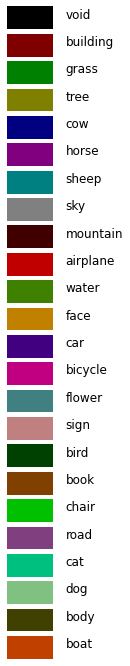

First picture of batch no. 1 out of 14


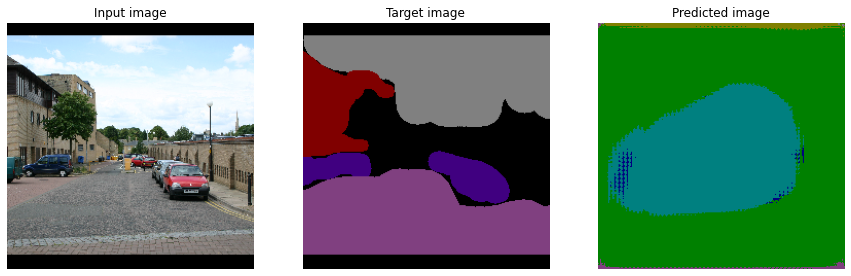

First picture of batch no. 2 out of 14


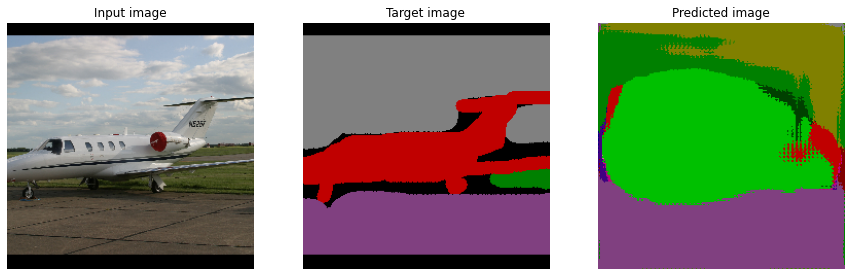

First picture of batch no. 3 out of 14


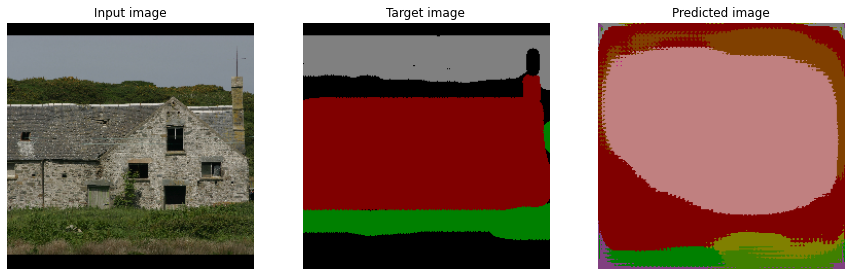

First picture of batch no. 4 out of 14


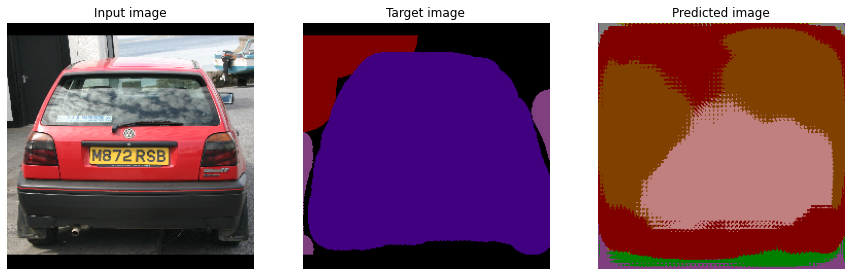

First picture of batch no. 5 out of 14


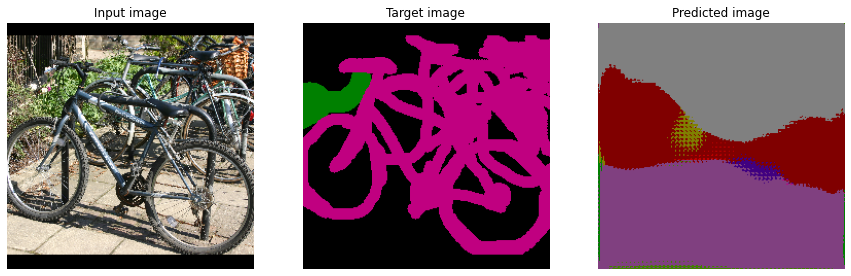

First picture of batch no. 6 out of 14


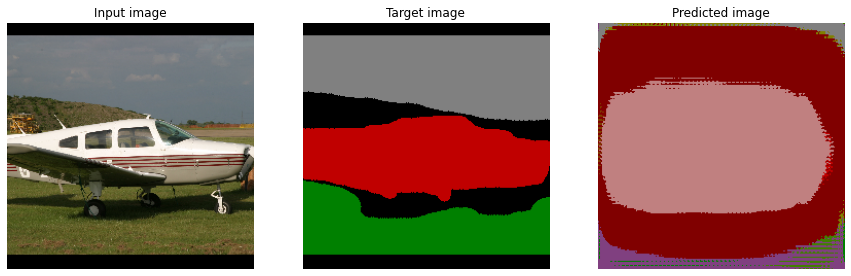

First picture of batch no. 7 out of 14


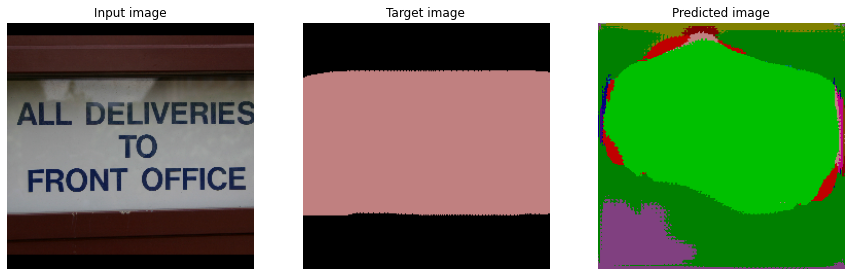

First picture of batch no. 8 out of 14


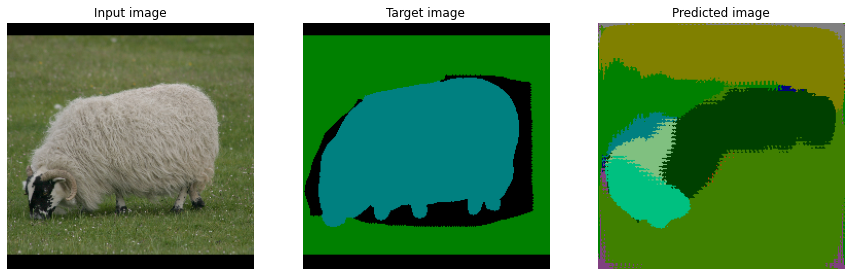

First picture of batch no. 9 out of 14


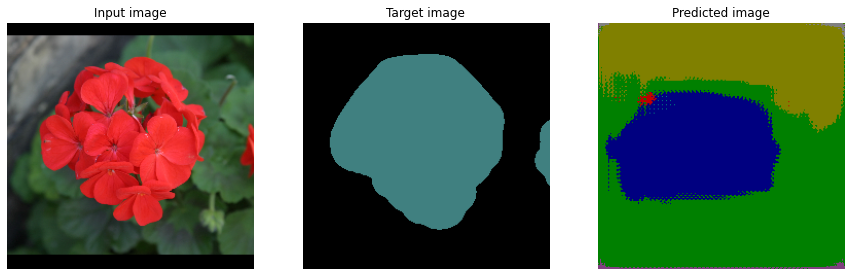

First picture of batch no. 10 out of 14


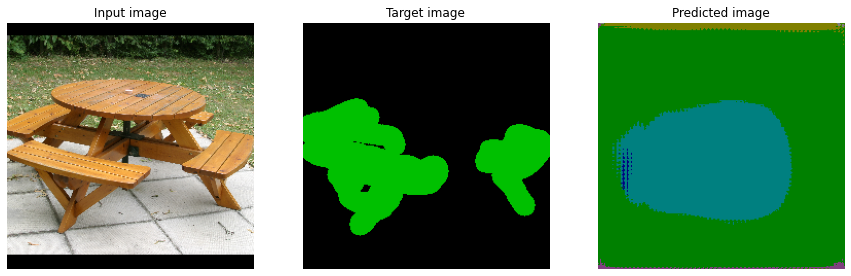

First picture of batch no. 11 out of 14


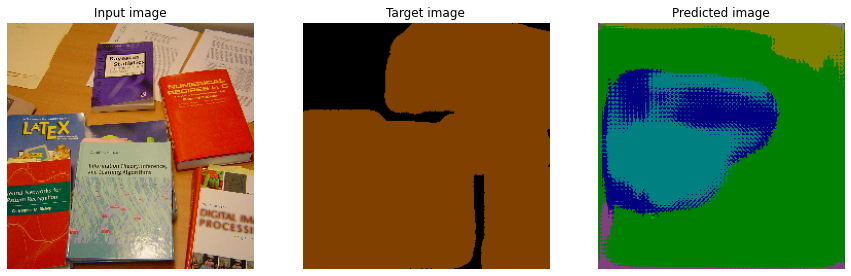

First picture of batch no. 12 out of 14


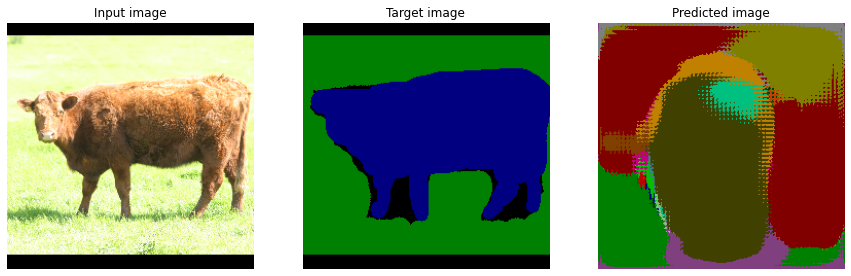

First picture of batch no. 13 out of 14


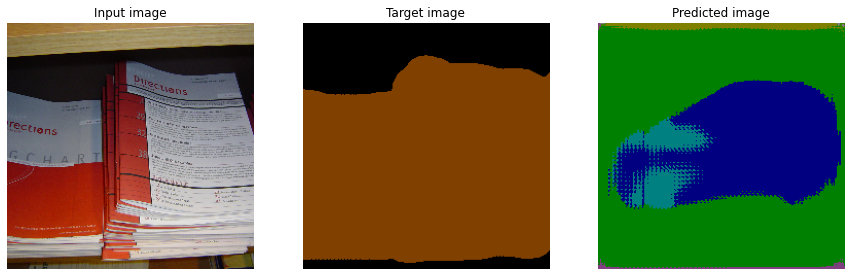

First picture of batch no. 14 out of 14


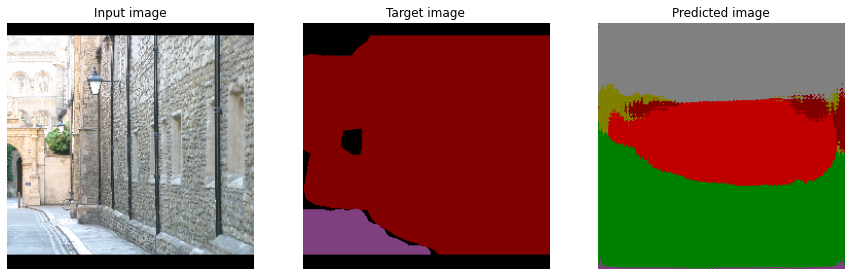

In [80]:
# Function for performance evaluation
def perfeval(nnmodel, data_loader, verbose:bool=True):
    """Evaluate performance metrics of multiclass classification model for images

    Args:
        :param nnmodel (torch.nn.Module): Pytorch network
        :param data_loader (torch.utils.data.DataLoader): Dataloader holding the minibatches of data and actual labels.
        :param verbose (bool, optional): Verbosity for reporting by-batch accuracies. Defaults to True.

    Returns:
        :return dict: Dictionary with these keys:
                        "total_accuracy": float between 0 and 1, for the whole data
                        "predictions": list of pytorch tensors holding class numbers as predicted by the model for every batch
                        "accuracies": list of accuracies for the batches
    """
    nnmodel.eval()
    preds = []
    accus = []
    corrects = 0
    numdata = 0
    with torch.no_grad():
        for i, (X,y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = torch.log_softmax(nnmodel(X).float(), dim=1)
            c_pred = torch.max(y_pred,1)[1]
            batch_corrects = torch.count_nonzero(y == c_pred)
            acc = batch_corrects/torch.numel(y)
            corrects += batch_corrects
            numdata += torch.numel(y)
            if verbose: print("Batch number {:2d} out of {:2d}: Accuracy: {} %".format(i+1, len(data_loader), acc * 100))
            preds.append(c_pred.cpu())
            accus.append(acc.cpu())
    return {"total_accuracy":corrects/numdata, "predictions":preds, "accuracies":accus}

# Calculating model performance for all dataset    
train_perfs = perfeval(model, train_loader, verbose=False)
val_perfs = perfeval(model, val_loader, verbose=False)
test_perfs = perfeval(model, test_loader)

# Illustrating the colorkey
from datasets.segmentation_dataset import SEG_LABELS_LIST
colorlist = [colordict['rgb_values'] for colordict in SEG_LABELS_LIST]
namelist = [colordict['name'] for colordict in SEG_LABELS_LIST]
icon = (25, 50, 3)
piclist = [np.array([r,g,b], dtype="int")*np.ones(icon, dtype='int') for r,g,b in colorlist]
print("Colorkey for semantic segmentation:")
plt.figure(figsize=(2,12))
i = 0
for idx in range(24):
    i += 1
    plt.subplot(24,2,i)
    plt.imshow(piclist[idx])
    plt.axis('off')
    i += 1
    plt.subplot(24,2,i)
    plt.text(0,0.5,namelist[idx], fontsize=12)
    plt.axis('off')
plt.show()
    
# Illustrating results of the first picture in every batch
for i, (X,y) in enumerate(test_loader):
    print('First picture of batch no. %d out of %d'%(i+1,len(test_loader)))
    c_pred = test_perfs["predictions"][i]
    pic = X[0,:,:,:].numpy().transpose(1,2,0)
    lbl_pred = c_pred[0,:,:].numpy()
    lbl_act = y[0,:,:].numpy()
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(pic)
    plt.axis('off')
    plt.title("Input image")
    plt.subplot(1,3,2)
    plt.imshow(label_img_to_rgb(lbl_act))
    plt.axis('off')
    plt.title("Target image")
    plt.subplot(1,3,3)
    plt.imshow(label_img_to_rgb(lbl_pred))
    plt.axis('off')
    plt.title("Predicted image")
    plt.show()

### Performance Summary


In [81]:
# Training set performance
print("Overall training set accuracy:   {} %".format(train_perfs["total_accuracy"]*100))
print("Overall validation set accuracy: {} %".format(val_perfs["total_accuracy"]*100))
print("Overall test set accuracy:       {} %".format(test_perfs["total_accuracy"]*100))

Overall training set accuracy:   60.75776290893555 %
Overall validation set accuracy: 55.07032775878906 %
Overall test set accuracy:       54.693050384521484 %


In [ ]:
# TODO: add validation into training loop for per epoch ==> DONE.
# TODO: add test code and visualize some results ==> DONE.
# -------
# TODO: Perform weighted CrossEntropyLoss according to which classes have more data. Then, class -1 (void) can also be included.
# TODO: Perform the same operation with other libraries as an exercise.
# TODO: Impvoe the model itself to get better results. Include regularization.